# Code for more tranditional compression experiments

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_compression as tfc
import re
import random
import numpy as np
import os
from astropy.io import fits

# Specify the directory containing the .tar files
directory_path = './columbialensing/'

single_cosmology = True #if true, only use one cosmology
# image_size
image_size = 1024
sub_image_size = 128 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations



number_subimages_across =image_size//sub_image_size


number_image_files = 512
suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}"



def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    if dir_name.endswith('.tar'):
        dir_name = dir_name[:-4]

    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])
    print (om_label, si_label)

    return [om_label, si_label]

#selects the numdirs closest to the fiducial directory
#STILL WORKING ON THIS CODE
def select_some_directories(numdirs, fiducial_dir):
    all_directories = [f for f in os.listdir(directory_path) if '128' not in f and '256' not in f]
    print(all_directories)
    #cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)
    fiducial_label = get_labels_for_file(fiducial_dir)
    labels = [get_labels_for_file(directory) for directory in all_directories] 
    print(labels)
    #to evlauate closeness
    closeness = pow(labels[:][0]/.3, 0.5)*label[:][1]
    fiducial = pow(fiducial_label[0]/.3, 0.5)*fiducial_label[1]

    #sort by closeness
    sorted_closeness = np.argsort(np.abs(closeness-fiducial))
    #select numdirs closest
    selected_dirs = sorted_closeness[:numdirs]
    return [all_directories[i] for i in selected_dirs]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")

if single_cosmology:
    all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
else:
    numdirs = 10
    all_directories = select_some_directories(numdirs, "Om0.268_si0.801")
    print(all_directories)


num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_image_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float32)
for idy, dir_name in enumerate(all_directories):


    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data #take log of data 

            if RMS == 0: #get RMS to divide by for first file to normalize everything
                RMS = np.sqrt(np.var(hdul[0].data))
                print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]
    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]
WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension




2024-01-04 14:00:14.146475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


reading in Om0.268_si0.801
RMS=0.018752897158265114
0.268 0.801


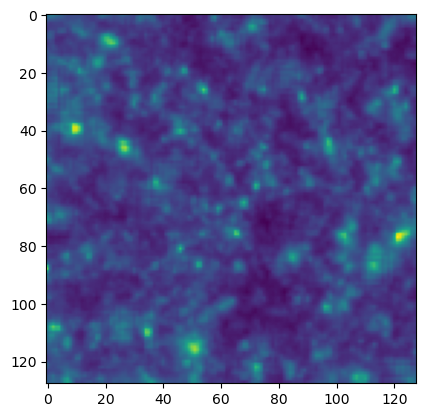

In [28]:
dataset = tf.data.Dataset.from_tensor_slices(WL_tensor)
#training_dataset = dataset.take(train_size)
(originals), =  dataset.batch(128).skip(3).take(1) #simpler problem to start with

plt.imshow(tf.squeeze(originals[0]))

92 [[ 0.          1.          2.         ... 62.         63.
  64.        ]
 [ 1.          1.41421356  2.23606798 ... 62.00806399 63.00793601
  64.00781202]
 [ 2.          2.23606798  2.82842712 ... 62.03224968 63.03173804
  64.03124237]
 ...
 [ 3.          3.16227766  3.60555128 ... 62.07253821 63.07138812
  64.07027392]
 [ 2.          2.23606798  2.82842712 ... 62.03224968 63.03173804
  64.03124237]
 [ 1.          1.41421356  2.23606798 ... 62.00806399 63.00793601
  64.00781202]]


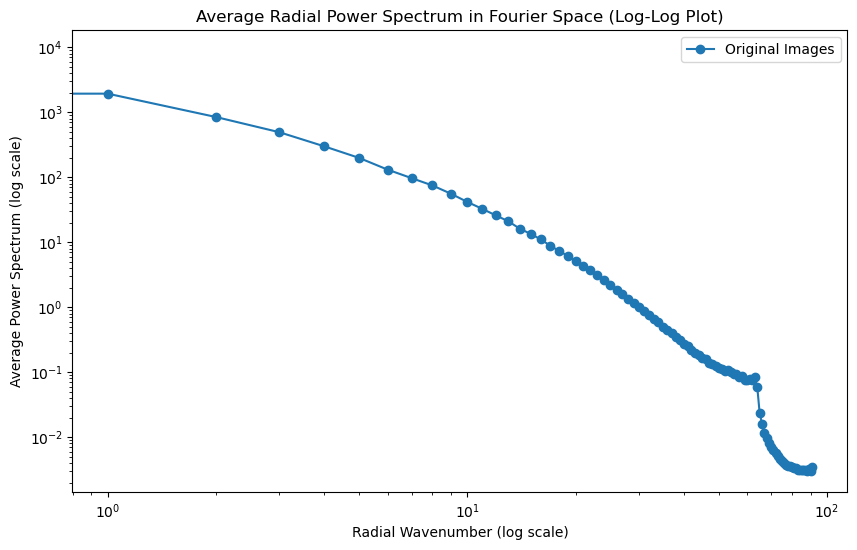

In [29]:
def fft_radial_distance(shape):
    # Create indices for the Fourier space
    kx, ky = np.meshgrid(np.fft.rfftfreq(shape), np.fft.fftfreq(shape))
    k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space
    return k

def radial_bin_average(image_fft, radial_dist):
    # Calculate the magnitude of the FFT (power spectrum)
    magnitude = np.abs(image_fft)**2

    # Bin the values based on radial distance
    radial_dist_int = np.rint(radial_dist).astype(int)
    tbin = np.bincount(radial_dist_int.ravel(), magnitude.ravel())
    nr = np.bincount(radial_dist_int.ravel())
    #print(tbin, nr)
    radial_profile = tbin / nr
    return radial_profile

def average_fft_power_spectrum(fftimages, shape):
    num_images = len(fftimages)
    radial_dist = fft_radial_distance(shape)
    
    # Calculate the maximum bin index, rounding up to the nearest integer
    max_bin_index = int(np.ceil(np.max(radial_dist))+1)
    print(max_bin_index, radial_dist)
    
    # Initialize the sum of radial power spectra
    sum_radial_power_spectrum = np.zeros(max_bin_index)
    
    for fftimage in fftimages:
        #fftimage = np.fft.fftshift(fftimage)
        radial_power_spectrum = radial_bin_average(fftimage, radial_dist)
        sum_radial_power_spectrum += radial_power_spectrum
    
    # Average across all images
    avg_radial_power_spectrum = sum_radial_power_spectrum / num_images
    return avg_radial_power_spectrum

#fft's of array
fftimages = [np.fft.rfft2(image) for image in tf.squeeze(originals)]

avg_radial_power_spectrum_originals = average_fft_power_spectrum(fftimages, sub_image_size) # does not need to be subimage size

plt.figure(figsize=(10, 6))

# Plot for originals with markers
plt.loglog(avg_radial_power_spectrum_originals, label='Original Images', marker='o', linestyle='-')

plt.xlabel('Radial Wavenumber (log scale)')
plt.ylabel('Average Power Spectrum (log scale)')
plt.title('Average Radial Power Spectrum in Fourier Space (Log-Log Plot)')
plt.legend()

plt.show()



(128, 128, 65)
(128, 65)
num pixels less than one: 0


2.016747270518859

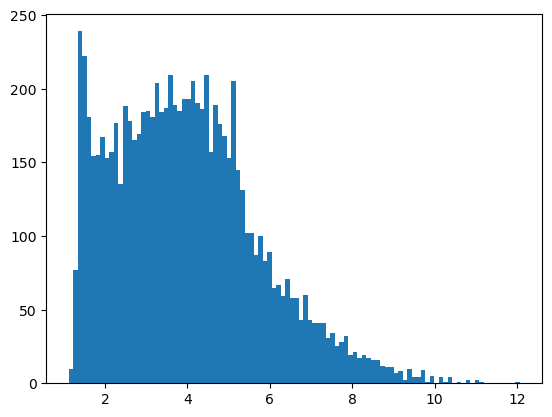

In [44]:
import matplotlib.pyplot as plt

#estimate number of pixels required to compress image with distortion D
D = 1e-4 #distortion

print(np.shape(fftimages))
#number of pixels required to compress image with distortion D
def num_bits_needed(D):
    pixel_variance = np.var(fftimages, axis=0)
    avg =np.average(pixel_variance)/np.sqrt(2) #divided by sqrt2 is because imaginary and real components are included in variance and each need to be separately encoded
    print(np.shape(pixel_variance))

    #really should set 

    # Assuming pixel_variance, D, and avg are defined
    condition = pixel_variance/(D*avg) < 1
    num_pixels_less_than_one = np.sum(condition)
    print(f"num pixels less than one: {num_pixels_less_than_one}")
    
    bits = 0.5*np.log2(pixel_variance/(D*avg))   # to do correct optimization should do pixel_variance[condition]
    

    plt.hist(bits.flatten(), bins=100)
    return np.sum(bits)/sub_image_size**2


num_bits_needed(D)

In [10]:
# tfc.NoisyNormal(loc=0., scale=tf.exp(self.prior_log_scales))   

#entropy_model = tfc.ContinuousBatchedEntropyModel(
#          self.prior, coding_rank=1, compression=False)

class Compressor(tf.keras.Model):
  """Compresses images to strings."""

  def __init__(self, entropy_model):
    super().__init__()
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype)  #/ 255.
  
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(x, training=False)
    return self.entropy_model.compress(x), bits
  
class Decompressor(tf.keras.Model):
  """Decompresses images from strings."""

  def __init__(self, entropy_model):
    super().__init__()
    self.entropy_model = entropy_model

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    # Scale and cast back to 8-bit integer.
    return y_hat #tf.saturate_cast(tf.round(x_hat), tf.uint8)





In [14]:
accuracy = 100  # part in one hundred accuracy
true_quantization = 1
if true_quantization:
    print("initializing entropy model...")
    #entropy_model = tfc.ContinuousBatchedEntropyModel(prior_shape=tfc.NoisyLogistic(loc=0., scale=(accuracy)), coding_rank=1, compression=True)
    #entropy_model = tfc.ContinuousBatchedEntropyModel(prior=tfc.NoisyNormal(loc=0., scale=(accuracy)), coding_rank=1, compression=True)
    entropy_model = tfc.ContinuousBatchedEntropyModel(tfc.NoisyLogistic(loc=0., scale=(accuracy*np.ones(sub_image_size*(sub_image_size+2)//2))), coding_rank=1, compression=True)
    print("entropy model initialized")
compressor = Compressor(entropy_model)
decompressor = Decompressor(entropy_model)

kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space

print(np.round(k[::16, ::16]))
sqrt2times_avg_radial_power = (2*avg_radial_power_spectrum_originals[np.round(k).astype(int)])**.5 #why sqrt 2?



fftimages_round = fftimages.copy()
num_images = 10 #len(fftimages)
for i in range(num_images):
    print("image", i)

    if true_quantization:
        fftimages_round[i] = fftimages_round[i] / sqrt2times_avg_radial_power
        
        
        real = tf.convert_to_tensor(np.real(accuracy*fftimages_round[i]), dtype=np.float32) #should convert to 32 earlier

        imag = tf.convert_to_tensor(np.imag(accuracy*fftimages_round[i]), dtype=np.float32) #should convert to 32 earlier
        #print("real.shape = ", real.shape)
        real = tf.reshape(real, [-1]); imag = tf.reshape(imag, [-1])
        comp_real,  rbits= compressor(real)
        comp_imag,  ibits= compressor(imag)

        print("bits = ", rbits+ibits)
        real = decompressor(comp_real); imag = decompressor(comp_imag)
        real = tf.reshape(real, [sub_image_size, -1]);  imag = tf.reshape(imag, [sub_image_size, -1])
        #print("real.shape = ", real.shape, imag.shape)
    
        #print("mean = ", np.mean(np.abs(fftimage_round)*2))
        #rounding
        #print(entropy_model.decompress(comp_real, shape))
        fftimages_round[i]  = (real.numpy() + 1j*imag.numpy())/accuracy*sqrt2times_avg_radial_power
        #print(comp_real.shape, fftimages_round[i].shape,  fftimages_round[i])

        #this was my simple rounding
    else: #pseudo-quantization
        fftimages_round[i] = np.round(fftimages_round[i] * accuracy) / accuracy * sqrt2times_avg_radial_power




rounded_images = [np.fft.irfft2(fftimage_round) for fftimage_round in fftimages_round]

#rounded_images  = rounded_images[..., np.newaxis] 

initializing entropy model...
entropy model initialized
[[ 0. 16. 32. 48. 64.]
 [16. 23. 36. 51. 66.]
 [32. 36. 45. 58. 72.]
 [48. 51. 58. 68. 80.]
 [64. 66. 72. 80. 91.]
 [48. 51. 58. 68. 80.]
 [32. 36. 45. 58. 72.]
 [16. 23. 36. 51. 66.]]
image 0
bits =  tf.Tensor(145526.93667995522, shape=(), dtype=float64)
image 1
bits =  tf.Tensor(145423.370705851, shape=(), dtype=float64)
image 2
bits =  tf.Tensor(145447.3906508548, shape=(), dtype=float64)
image 3
bits =  tf.Tensor(145564.22713682885, shape=(), dtype=float64)
image 4
bits =  tf.Tensor(145412.7042388412, shape=(), dtype=float64)
image 5
bits =  tf.Tensor(145503.53814720054, shape=(), dtype=float64)
image 6
bits =  tf.Tensor(145041.37799472295, shape=(), dtype=float64)
image 7
bits =  tf.Tensor(145036.70764763953, shape=(), dtype=float64)
image 8
bits =  tf.Tensor(144786.5717263671, shape=(), dtype=float64)
image 9
bits =  tf.Tensor(145146.02504809084, shape=(), dtype=float64)


-0.03160135481992692 0.25034738
diff_vmin and diff_vmax -0.01272473 0.012553617


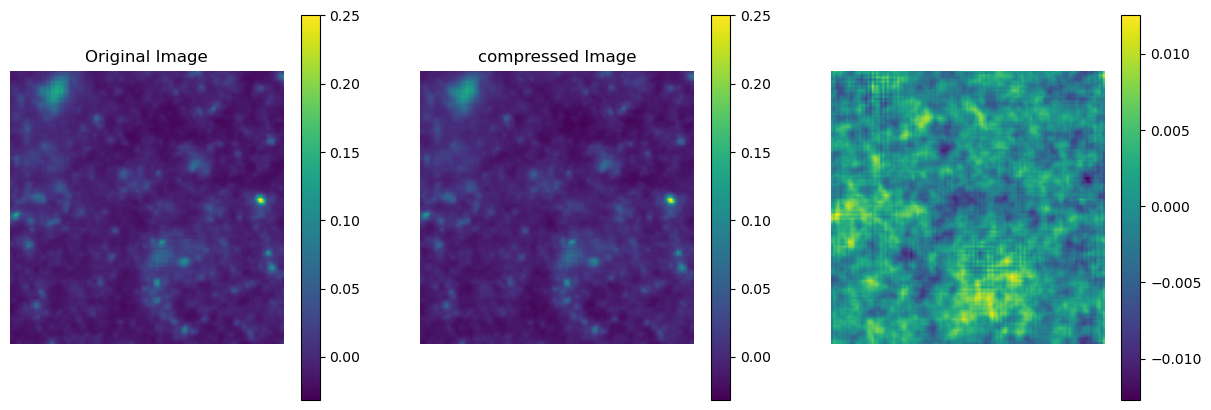

In [124]:
num_image = 2


# Assuming originals and reconstructions are your datasets
original_image = tf.squeeze(originals[num_image])

rounded_image = rounded_images[num_image]

# Determine the min and max values across both images for consistent scaling
vmin = min(original_image.numpy().min(), rounded_image.min())
vmax = max(original_image.numpy().max(), rounded_image.max())
print(vmin, vmax)

# Set up a figure with two subplots
plt.figure(figsize=(15, 5))  # You can adjust the figure size as needed

# Display the original image
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(original_image, vmin=vmin, vmax=vmax)
plt.title('Original Image')
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()

# Display the reconstructed image
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(rounded_image, vmin=vmin, vmax=vmax)
plt.title('compressed Image')
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()


# Determine the scale for the difference image
difference_image = original_image - rounded_image
diff_vmin = difference_image.numpy().min()
diff_vmax = difference_image.numpy().max()

print("diff_vmin and diff_vmax",  diff_vmin, diff_vmax)
plt.subplot(1, 3, 3)
image_display= plt.imshow(difference_image, vmin=diff_vmin, vmax=diff_vmax)
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()



# Loyd max quantizer

In [54]:
import numpy as np
from scipy.stats import norm

def lloyd_max_quantizer(mu, sigma, levels):
    # Initialize decision boundaries
    decision_boundaries = np.linspace(mu - 5*sigma, mu + 5*sigma, levels+1)

    # Initialize reconstruction levels
    reconstruction_levels = np.zeros(levels)

    while True:
        # Update reconstruction levels
        for i in range(levels):
            left_boundary = decision_boundaries[i]
            right_boundary = decision_boundaries[i+1]
            #reconstruction_levels[i] = norm.expect(lambda x: x, args=(mu, sigma), lb=left_boundary, ub=right_boundary) / \
            #                           norm.expect(lambda x: 1, args=(mu, sigma), lb=left_boundary, ub=right_boundary)
            reconstruction_levels[i] = norm.expect(lambda x: x, loc=mu, scale=sigma, lb=left_boundary, ub=right_boundary) / \
                           norm.expect(lambda x: 1, loc=mu, scale=sigma, lb=left_boundary, ub=right_boundary)

        

        # Update decision boundaries
        new_decision_boundaries = (reconstruction_levels[:-1] + reconstruction_levels[1:]) / 2

        # Check for convergence
        if np.allclose(new_decision_boundaries, decision_boundaries[1:-1]):
            break

        decision_boundaries[1:-1] = new_decision_boundaries

    return decision_boundaries, reconstruction_levels

# Test the function
mu = 0
sigma = 1
max_levels = 10

quantization_values = {}

for levels in range(1, max_levels):
    decision_boundaries, reconstruction_levels = lloyd_max_quantizer(mu, sigma, levels)

    print("level = " , levels)
    print("Decision boundaries: ", decision_boundaries)
    print("Reconstruction levels: ", reconstruction_levels)
    quantization_values[levels] = [decision_boundaries, reconstruction_levels]

kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space

print(np.round(k[::16, ::16]))


level =  1
Decision boundaries:  [-5.  5.]
Reconstruction levels:  [0.]
level =  2
Decision boundaries:  [-5.  0.  5.]
Reconstruction levels:  [-0.79788204  0.79788204]
level =  3
Decision boundaries:  [-5.         -0.61200913  0.61200913  5.        ]
Reconstruction levels:  [-1.22400662  0.          1.22400662]
level =  4
Decision boundaries:  [-5.00000000e+00 -9.81612022e-01 -1.38777878e-16  9.81612022e-01
  5.00000000e+00]
Reconstruction levels:  [-1.51042169 -0.45278514  0.45278514  1.51042169]
level =  5
Decision boundaries:  [-5.         -1.24437281 -0.38229263  0.38229263  1.24437281  5.        ]
Reconstruction levels:  [-1.72415078e+00 -7.64578232e-01  1.86431881e-16  7.64578232e-01
  1.72415078e+00]
level =  6
Decision boundaries:  [-5.00000000e+00 -1.44687265e+00 -6.58931821e-01 -1.94289029e-16
  6.58931821e-01  1.44687265e+00  5.00000000e+00]
Reconstruction levels:  [-1.89360085 -1.00012621 -0.31772559  0.31772559  1.00012621  1.89360085]
level =  7
Decision boundaries:  [-5

In [138]:
kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space
avg_radial_power = avg_radial_power_spectrum_originals[np.round(k).astype(int)]
sqrt_avg_radial_power = np.sqrt(avg_radial_power/2) #2 is because of real and imaginary parts


def quantize_image(image, level, decision_boundaries, reconstruction_levels):
    # Create arrays to hold the quantized real and imaginary parts
    quantized_real = np.zeros_like(image.real)
    quantized_imag = np.zeros_like(image.imag)

    # Loop over each level
    for i in range(max_levels-1):
        print(i, np.shape(image.real), np.shape(level), np.shape(decision_boundaries[level]), np.shape(decision_boundaries[level][i+1]))
        # Find the pixels in the current level for the real part
        if i == 0:  # For the first level, include the left boundary
            in_level_real = (image.real >= decision_boundaries[level][i]) & (image.real < decision_boundaries[level][i+1])
        else:  # For other levels, do not include the left boundary
            in_level_real = (image.real > decision_boundaries[level][i]) & (image.real <= decision_boundaries[level][i+1])

        # Set these pixels to the corresponding reconstruction level
        quantized_real[in_level_real] = reconstruction_levels[level][i]

        # Repeat for the imaginary part
        if i == 0:
            in_level_imag = (image.imag >= decision_boundaries[level][i]) & (image.imag < decision_boundaries[level][i+1])
        else:
            in_level_imag = (image.imag > decision_boundaries[level][i]) & (image.imag <= decision_boundaries[level][i+1])

        quantized_imag[in_level_imag] = reconstruction_levels[level][i]

    # Combine the quantized real and imaginary parts into a complex array
    quantized_image = quantized_real + 1j*quantized_imag

    return quantized_image


# Get the decision boundaries and reconstruction levels for the desired level
#decision_boundaries, reconstruction_levels = quantization_values[level]

# Initialize lists to store decision boundaries and reconstruction levels
decision_boundaries_list = [[]]
reconstruction_levels_list = [[]]

# Loop over each level from 1 to max_level-1
for level in range(1, max_levels):
    decision_boundary, reconstruction_level = quantization_values[level]
    # Create new arrays filled with zeros
    new_decision_boundary = np.zeros(max_levels + 1)
    new_reconstruction_level = np.zeros(max_levels)

    # Copy elements, leaving the ends as zero
    new_decision_boundary[:level+1] = decision_boundary[:level+1]
    new_reconstruction_level[:level] = reconstruction_level[:level]

    decision_boundaries_list.append(new_decision_boundary)
    reconstruction_levels_list.append(new_reconstruction_level)

# Convert lists to arrays
decision_boundaries = np.array(decision_boundaries_list)
reconstruction_levels = np.array(reconstruction_levels_list)

level = 8
print("db shapes ", np.shape(decision_boundaries[level]), np.shape(reconstruction_levels[level]))

fftimages_round = fftimages.copy()

single_level = 0
Distortion = 0.01
if single_level:
    level = 8
else:
    level = np.minimum(np.ceil(avg_radial_power/(2*np.average(avg_radial_power)*Distortion)).astype(int), max_levels-1)


print(np.shape(decision_boundaries[level.flatten()]), np.shape(reconstruction_levels[level]), np.shape(level), np.shape(fftimages_round[i]))

for i in range(len(fftimages_round)):
    # Quantize the image   
    #print(np.std(fftimages_round[i]/sqrt_avg_radial_power/np.sqrt(2)))
    fftimages_round[i] = quantize_image(fftimages_round[i]/sqrt_avg_radial_power, level, decision_boundaries, reconstruction_levels)*sqrt_avg_radial_power

rounded_images = [np.fft.irfft2(fftimage_round) for fftimage_round in fftimages_round]

db shapes  (11,) (10,)
(8320,) (128, 65) (128, 65) (128, 65)
0 (128, 65) (128, 65) (128, 65) (65,)


/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_83216/3269580090.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  decision_boundaries = np.array(decision_boundaries_list)
/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_83216/3269580090.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  reconstruction_levels = np.array(reconstruction_levels_list)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()